# Vertically integrated water vapour (VIWV) and its transport (IVT)

Notebook to compute vertically integrated water vapour (VIWV) and its transport (IVT)

## Libraries

In [1]:
# Basic Libraries
import numpy as np
import xarray as xr
import os
import glob

# WRF library
import wrf

# Plot libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.patches as patches
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib import font_manager


## Open datasets

Define paths

In [2]:
# define main paths for observations and reanalysis + for simulations
obs_path = '/media/irene/Elements/Laptop_dec2023/Thesis_data/obs/'
sim_path = '/media/irene/Elements/wrf_micro/'


Define microphysics names and variables

In [3]:
schemes = ["Thompson", "Morrison", "CAM", "Ylin", "WDM7", "WDM6"]
variables = ["QV", "U", "V", "P", "PB"]


Define vertical levels

In [4]:
ulev=[30,50,70,100,125,150,175,200,225,250,300,350,400,450,500,550,600,650,700,750,775,800,825,850,875,900,925,950,975]


Open datasets

In [5]:
# Open datasets
#ERA5: Q, U, V
ds_ERA = xr.open_dataset(f'{obs_path}/ERA5-WTQ-MCScase.nc') 
ds_uERA, ds_vERA = xr.open_dataset(f'{obs_path}/ERA5-UV-MCScase.nc'), xr.open_dataset(f'{obs_path}/ERA5-UV-MCScase.nc') 
ds_ivtERA = xr.open_dataset(f'{obs_path}/ERA5-IVT-MCScase.nc') 

# WRF
ds = {var: {} for var in variables}

# Loop through schemes and variables to load datasets
for scheme in schemes:
    for var in variables:
        pattern = os.path.join(sim_path, scheme, f"reg_*_{var}-16to24.nc")
        files = sorted(glob.glob(pattern))

        if not files:
            print(f"[WARNING] No files found for: {scheme} - {var}")
            continue

        if len(files) == 1:
            ds[var][scheme] = xr.open_dataset(files[0])
            

## Cut to right temporal and spatial domain

In [6]:
# Cut time
ds_ERA = ds_ERA.sel(time=slice('2008-07-16T00:00:00.000000000', '2008-07-24T23:00:00.000000000'))


Define spatial domain

In [7]:
# Define Sichuan Basin
lat1, lat2 = 26, 35
lon1, lon2 = 100, 114


In [8]:
# ERA5
ds_ERA = ds_ERA.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))

# WRF
for var in ds:
    for scheme in ds[var]:
        ds[var][scheme] = ds[var][scheme].sel(latitude=slice(lat2, lat1), longitude=slice(lon1, lon2))
        

## Compute pressure levels

Compute pressure levels of WRF variables (to convert from WRf vertical coordinate system to ERA5 vertical coordinates)

In [9]:
# Compute pressure levels of wrf variables
pr_lev = {}
for scheme in schemes:
    pr_lev[scheme] = (ds["P"][scheme].P + ds["PB"][scheme].PB) / 100  #100 convert to hPa
    

Now to average over time to be able to interpolate, because interpolation is max for 3D variables

In [10]:
pr_lev_mean = {scheme: pr_lev[scheme].mean(dim="XTIME") for scheme in schemes}


## Prepare data

Average Q, V, U over time for IVT computation

In [11]:
# WRF
meant_q = {scheme: ds["QV"][scheme].QVAPOR.mean("XTIME") for scheme in schemes}
meant_u = {scheme: ds["U"][scheme].U.mean("XTIME") for scheme in schemes}
meant_v = {scheme: ds["V"][scheme].V.mean("XTIME") for scheme in schemes}

# ERA5 (q: kg/kg - u,v: m/s)
meant_qERA = ds_ERA.q.mean('time').sel(level=ulev)
meant_uERA = ds_uERA.u.mean('time').sel(level=ulev)
meant_vERA = ds_vERA.v.mean('time').sel(level=ulev)


3D interpolation of WRF over shared WRF and ERA5 vertical levels

In [12]:
# WRF
imeant_q = {}
imeant_u = {}
imeant_v = {}

for scheme in schemes:
    plevel = pr_lev_mean[scheme]
    imeant_q[scheme] = wrf.interplevel(meant_q[scheme], plevel, ulev)
    imeant_u[scheme] = wrf.interplevel(meant_u[scheme], plevel, ulev)
    imeant_v[scheme] = wrf.interplevel(meant_v[scheme], plevel, ulev)
    

## Compute IVT

Define function to compute IVT

In [13]:
def IVT(values, pressure_levels):
    """ This function calculates the column-integrated water vapor transport                                                                                            
    in kg/m2 from specific humidity (kg/kg)* winds at different hPa levels. 

    Parameters: 
       values(array-like): 3D field of specific humidity * horizontal winds (level,lat,lon)
       pressure_levels(array-like) : 1D field with corresponding pressure levels in hPa                       

    Returns: 
      2D field with column-integrated values 
    """
    values = np.nan_to_num(values, nan=0.0)
    g = 9.81 # gravitational acceleration (needed because levels are given in pressure, not height)                                                                                                                   
    return np.trapz(values, pressure_levels, axis = 0)* (1/g) *100 # axis=0 integrated along vertical dimension, *100 for hPa not Pa
    

Compute products Q*winds (averaged over time)

In [14]:
# ERA5
meant_quERA, meant_qvERA = meant_qERA*meant_uERA, meant_qERA*meant_vERA

# WRF
meant_qu = {}
meant_qv = {}

for scheme in schemes:
    meant_qu[scheme] = imeant_q[scheme] * imeant_u[scheme]
    meant_qv[scheme] = imeant_q[scheme] * imeant_v[scheme]
    

Compute south-north and west-east components of IVT

In [15]:
# ERA5
qu_intERA, qv_intERA = IVT(meant_quERA, meant_quERA.level), IVT(meant_qvERA, meant_qvERA.level)

# WRF
qu_int = {}
qv_int = {}

for scheme in schemes:
    qu_int[scheme] = IVT(meant_qu[scheme], meant_qu[scheme].level)
    qv_int[scheme] = IVT(meant_qv[scheme], meant_qv[scheme].level)


In [27]:
# ERA5
IVT_ERA = np.sqrt(qu_intERA**2 + qv_intERA**2)

# WRF
IVT_s = {}

for scheme in schemes:
    IVT_s[scheme] = np.sqrt(qu_int[scheme]**2 + qv_int[scheme]**2)
    

## Plot maps

Add elevation data

In [17]:
# Elevation
elevation_data =  xr.open_dataset('/media/irene/Elements/Laptop_dec2023/Thesis_data/script/scripts29May/geopotential.nc')
height = elevation_data/9.81
height = height.sel(latitude=slice(lat2,lat1), longitude=slice(lon1,lon2))


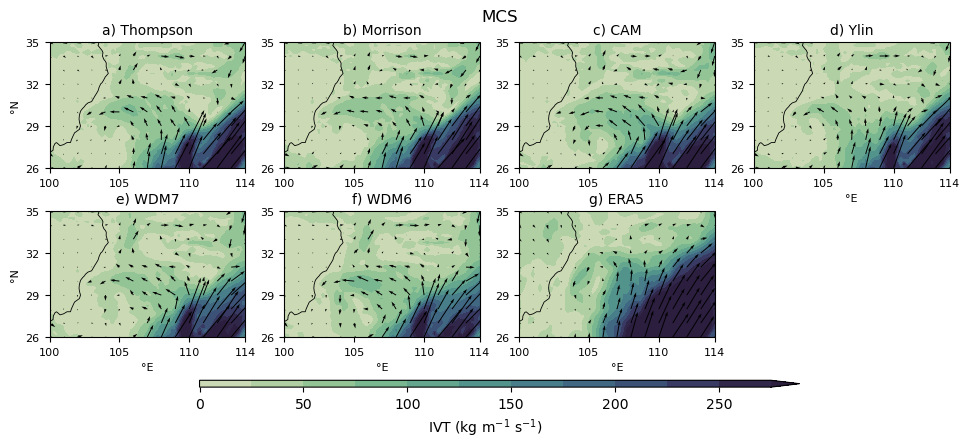

In [18]:
# Prepare data lists and titles
ds = [IVT_s[s] for s in schemes] + [IVT_ERA]
ds_qu = [qu_int[s] for s in schemes] + [qu_intERA]
ds_qv = [qv_int[s] for s in schemes] + [qv_intERA]
titles = ['a) Thompson', 'b) Morrison', 'c) CAM', 'd) Ylin', 'e) WDM7', 'f) WDM6', 'g) ERA5']

# Figure setup
fig, axs = plt.subplots(2, 4, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 3.8))
axs = axs.flatten()
fig.suptitle('MCS', y=1)

clevs = np.arange(0, 300, 25)
step = 4
cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

for i in range(7):
    ax = axs[i]
    ax.set_xticks([100, 105, 110, 114])
    ax.set_yticks([26, 29, 32, 35])
    ax.tick_params(axis='x', labelsize=8)  
    ax.tick_params(axis='y', labelsize=8)

    # Filled contour plot
    c0 = ax.contourf(ds_ERA.longitude, ds_ERA.latitude, ds[i], clevs, cmap=cmap, extend='max')
    # Quiver plot with subsampling
    ax.quiver(ds_ERA.longitude[::step], ds_ERA.latitude[::step], ds_qu[i][::step, ::step], ds_qv[i][::step, ::step], color='k')
    # Contour of height at 3000 m
    ax.contour(height.z.longitude.values, height.z.latitude.values, height.z[0], levels=[3000], colors='black', linewidths=0.6)

    ax.set_title(titles[i], fontsize=10)

# Set axis labels for specific subplots
axs[0].set_ylabel('°N', fontsize=8)
axs[3].set_xlabel('°E', fontsize=8)
axs[4].set_xlabel('°E', fontsize=8)
axs[4].set_ylabel('°N', fontsize=8)
axs[5].set_xlabel('°E', fontsize=8)
axs[6].set_xlabel('°E', fontsize=8)

# Remove the empty subplot (axs[7])
fig.delaxes(axs[7])

# Colorbar axis at the bottom
cbar_ax = fig.add_axes([0.2, 0.005, 0.6, 0.018])
cbar = fig.colorbar(c0, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=10)
cbar.ax.tick_params(labelsize=10)

fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.2, hspace=0.1)


Compute differences using ERA5 as reference

In [19]:
diffIVT = {}
diffqu_int = {}
diffqv_int = {}

for scheme in schemes:
    diffIVT[scheme] = IVT[scheme] - IVT_ERA
    diffqu_int[scheme] = qu_int[scheme] - qu_intERA
    diffqv_int[scheme] = qv_int[scheme] - qv_intERA
    

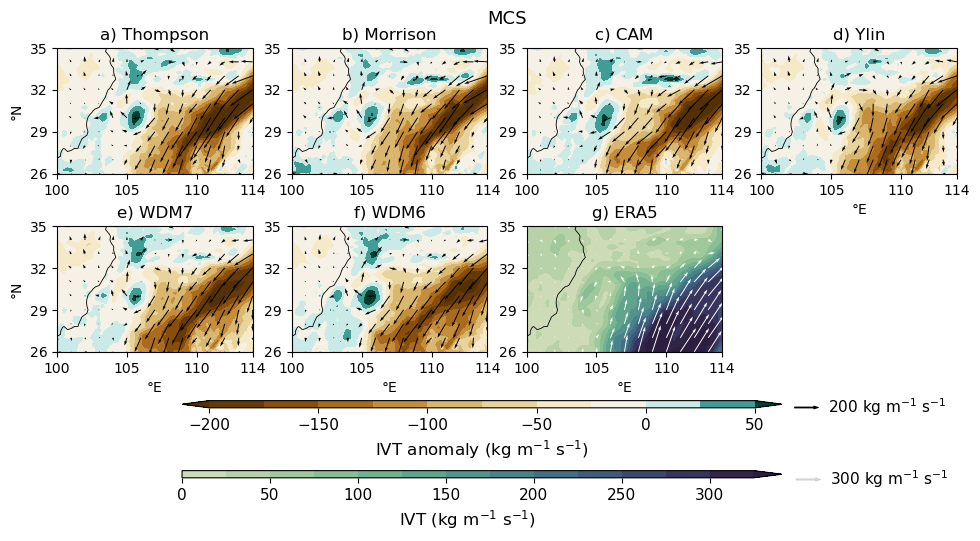

In [20]:
# Prepare lists for plotting, appending ERA data at the end
ds = [diffIVT[scheme] for scheme in schemes] + [IVT_ERA]
ds_qu = [diffqu_int[scheme] for scheme in schemes] + [qu_intERA]
ds_qv = [diffqv_int[scheme] for scheme in schemes] + [qv_intERA]
titl = ['a) Thompson', 'b) Morrison', 'c) CAM', 'd) Ylin', 'e) WDM7', 'f) WDM6', 'g) ERA5']

fig, axs = plt.subplots(nrows=2, ncols=4, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 4))
axs = axs.flatten()
fig.suptitle('MCS', y=1, fontsize=13)

clevs = np.arange(-200, 65.1, 25)
clevs1 = np.arange(0, 350, 25)
scale = 9000  # set scale for arrows
step = 4
cmap = 'BrBG'

# Normalized colormap centered at zero for anomalies
norm = mcolors.TwoSlopeNorm(vmin=-200, vmax=65.1, vcenter=0)

cmap1 = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

for j in range(7):
    axs[j].set_xticks([100, 105, 110, 114])
    axs[j].set_yticks([26, 29, 32, 35])
    axs[j].tick_params(axis='x', labelsize=10)
    axs[j].tick_params(axis='y', labelsize=10)

for i in range(6):
    c0 = axs[i].contourf(ds_ERA.longitude, ds_ERA.latitude, ds[i], clevs, cmap=cmap, norm=norm, extend='both')
    quiver_plot = axs[i].quiver(ds_ERA.longitude[::step], ds_ERA.latitude[::step], ds_qu[i][::step, ::step], ds_qv[i][::step, ::step], color='k')
    axs[i].contour(height.z.longitude.values, height.z.latitude.values, height.z[0], levels=[3000], colors='black', linewidths=0.6)
    axs[i].set_title(titl[i], fontsize=12)

# ERA5 plot
c6 = axs[6].contourf(ds_ERA.longitude, ds_ERA.latitude, IVT_ERA, clevs1, cmap=cmap1, extend='max')
quiver_plotE = axs[6].quiver(ds_ERA.longitude[::step], ds_ERA.latitude[::step], qu_intERA[::step, ::step], qv_intERA[::step, ::step], color='w')
axs[6].contour(height.z.longitude.values, height.z.latitude.values, height.z[0], levels=[3000], colors='k', linewidths=0.6)
axs[6].set_xlabel('°E', fontsize=10)
axs[6].set_title('g) ERA5', fontsize=12)

axs[5].quiverkey(quiver_plot, X=2.69, Y=-0.44, U=200, color='k', label=r'200 kg m$^{-1}$ s$^{-1}$', labelpos='E', lw=0.6, fontproperties=font_manager.FontProperties(size=11))
axs[6].quiverkey(quiver_plotE, X=1.5, Y=-1.01, U=300, color='#d3d3d3', label=r'300 kg m$^{-1}$ s$^{-1}$', labelpos='E', lw=0.8, fontproperties=font_manager.FontProperties(size=11))

axs[0].set_ylabel('°N', fontsize=10)
axs[3].set_xlabel('°E', fontsize=10)
axs[4].set_xlabel('°E', fontsize=10)
axs[4].set_ylabel('°N', fontsize=10)
axs[5].set_xlabel('°E', fontsize=10)
axs[6].set_xlabel('°E', fontsize=10)

# Remove the empty subplot (axs[7])
fig.delaxes(axs[7])

# Add colorbar for anomalies
cbar_ax = fig.add_axes([0.175, 0.005, 0.6, 0.018])
cbar = fig.colorbar(c0, cax=cbar_ax, orientation='horizontal')
cbar.set_label(r'IVT anomaly (kg m$^{-1}$ s$^{-1}$)', fontsize=12)
cbar.ax.tick_params(labelsize=11)

# Add colorbar for ERA IVT
cbar_ax2 = fig.add_axes([0.175, -0.17, 0.6, 0.018])
cbar2 = fig.colorbar(c6, cax=cbar_ax2, orientation='horizontal')
cbar2.set_label(r'IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=12)
cbar2.ax.tick_params(labelsize=11)

fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.2, hspace=0.1)


# VIWV: vertically integrated water vapour

Compute VIWV

In [36]:
viwv = {}

for scheme in schemes:
    viwv[scheme] = IVT(imeant_q[scheme], imeant_q[scheme].level)

viwv_ERA = IVT(meant_qERA, meant_qERA.level)

Define a personalised colormap

In [23]:
from matplotlib.cm import get_cmap

# Get the original BrBG colormap with many samples
original_cmap = get_cmap('BrBG', 256)

# Convert to list of colors
colors = original_cmap(np.linspace(0, 1, 256))

# Define how much of the middle to remove
trim_fraction = 0.15  # remove 15% from the center (can adjust)

# Calculate number of colors to keep from each end
n_trim = int(256 * trim_fraction / 2)
trimmed_colors = np.vstack([colors[:128 - n_trim], colors[128 + n_trim:]])

# Create the new trimmed colormap
trimmed_cmap = mcolors.LinearSegmentedColormap.from_list("BrBG_trimmed", trimmed_colors)


/tmp/ipykernel_10437/3624491875.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  original_cmap = get_cmap('BrBG', 256)


Plot

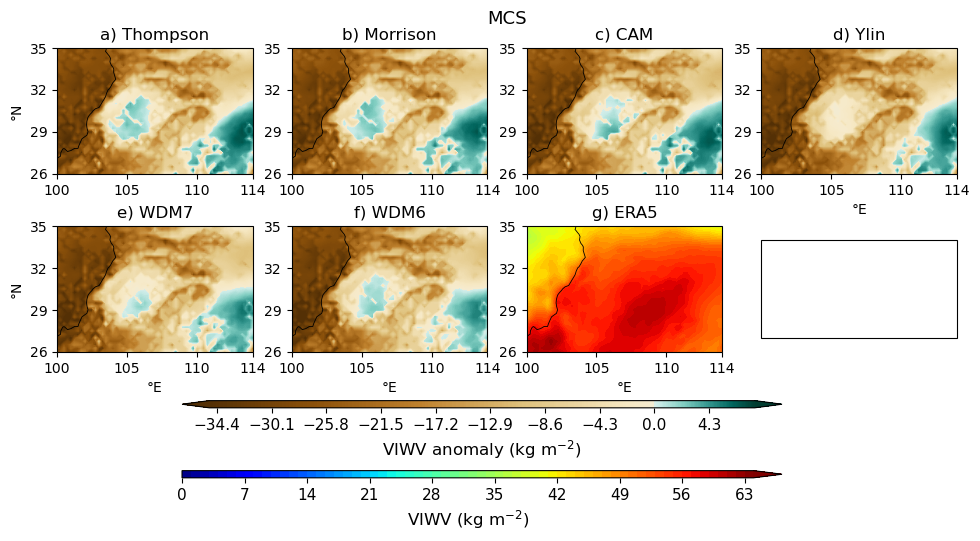

In [37]:
# Maps of anomalies for Article
from matplotlib import font_manager

ds = []
#datasets
ds = [viwv['Thompson'] - viwv_ERA, viwv['Morrison'] - viwv_ERA, viwv['CAM'] - viwv_ERA, viwv['Ylin'] - viwv_ERA,
      viwv['WDM7'] - viwv_ERA, viwv['WDM6'] - viwv_ERA, viwv_ERA]

titl=['a) Thompson', 'b) Morrison', 'c) CAM', 'd) Ylin', 'e) WDM7', 'f) WDM6', 'g) ERA5']

fig, axs = plt.subplots(nrows=2, ncols=4, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 4))
axs = axs.flatten()
fig.suptitle('MCS', y=1, fontsize=13)

clevs=np.arange(-35,8,0.1) #-35,8,1
clevs1=np.arange(0,65,1) #65,1

# Create a normalized colormap centered at 0
norm = mcolors.TwoSlopeNorm(vmin=-35, vmax=8, vcenter=0) #

cmap1 = sns.color_palette("flare", as_cmap=True)
cmap1 = sns.cubehelix_palette(start=.3, rot=-.75, as_cmap=True) 


for j in range(0,7):
    axs[j].set_xticks([100,105,110,114])
    axs[j].set_yticks([26,29,32,35])
    axs[j].tick_params(axis='x', labelsize=10)  
    axs[j].tick_params(axis='y', labelsize=10)
 
for i in range(0,6):
    c0 = axs[i].contourf(ds_ERA.longitude, ds_ERA.latitude, ds[i], clevs, cmap=trimmed_cmap, norm=norm, extend='both') #clevs, trimmed_cmap, norm=norm,
    axs[i].contour(height.z.longitude.values , height.z.latitude.values, height.z[0], levels=[3000], colors='black', linewidths=0.6)
    axs[i].set_title(f'{(3*titl)[i]}', fontsize = 12)

#era5
c6 = axs[6].contourf(ds_ERA.longitude, ds_ERA.latitude, ds[6], clevs1, cmap='jet', extend='max')
axs[6].contour(height.z.longitude.values , height.z.latitude.values, height.z[0], levels=[3000], colors='k', linewidths=0.6)
axs[6].set_xlabel('°E', fontsize=10)
axs[6].set_title('g) ERA5', fontsize=12)

axs[0].set_ylabel('°N', fontsize=10)
axs[3].set_xlabel('°E',fontsize=10)
axs[4].set_xlabel('°E',fontsize=10)
axs[4].set_ylabel('°N',fontsize=10)
axs[5].set_xlabel('°E',fontsize=10)
axs[6].set_xlabel('°E', fontsize=10)


# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.175, 0.005, 0.6, 0.018])
cbar=fig.colorbar(c0, cax=cbar_ax,orientation='horizontal')
cbar.set_label(r'VIWV anomaly (kg m$^{-2}$)', fontsize = 12)
cbar.ax.tick_params(labelsize=11)

# Add a 2nd colorbar axis at the bottom of the graph
cbar_ax2 = fig.add_axes([0.175, -0.17, 0.6, 0.018])
cbar2 = fig.colorbar(c6, cax=cbar_ax2,orientation='horizontal')
cbar2.set_label(r'VIWV (kg m$^{-2}$)', fontsize = 12)
cbar2.ax.tick_params(labelsize=11)

fig.subplots_adjust(bottom=0.1, top=0.95, left=0.05, right=0.95, wspace=0.2, hspace=0.1)
